In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader 
from torch.optim import Adam
import torchvision
import torchvision.models as models
from torchsummary import summary

torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data

In [2]:
batch_size = 256
train_transform = transforms.Compose(
    [   
        transforms.Resize((70, 70)),
        transforms.RandomCrop((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], 
                             [0.2470, 0.2435, 0.2616]),
    ])

val_transform = transforms.Compose(
    [
        transforms.Resize((70, 70)),
        transforms.RandomCrop((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], 
                             [0.2470, 0.2435, 0.2616])
    ])

train_set = CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=train_transform
)

val_set = CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=val_transform
)

trainloader = DataLoader(
    train_set, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
)

testloader = DataLoader(
    val_set, 
    batch_size=batch_size,
    shuffle=False, 
    num_workers=4,
)

Files already downloaded and verified
Files already downloaded and verified


## Model

In [3]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

# Replace the last fully-connected layer
model.classifier[6] = nn.Linear(4096, 10)

model = model.to(device)

Using cache found in /home/server-96gb-ailab/.cache/torch/hub/pytorch_vision_v0.6.0
/home/server-96gb-ailab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/server-96gb-ailab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 15, 15]          23,296
              ReLU-2           [-1, 64, 15, 15]               0
         MaxPool2d-3             [-1, 64, 7, 7]               0
            Conv2d-4            [-1, 192, 7, 7]         307,392
              ReLU-5            [-1, 192, 7, 7]               0
         MaxPool2d-6            [-1, 192, 3, 3]               0
            Conv2d-7            [-1, 384, 3, 3]         663,936
              ReLU-8            [-1, 384, 3, 3]               0
            Conv2d-9            [-1, 256, 3, 3]         884,992
             ReLU-10            [-1, 256, 3, 3]               0
           Conv2d-11            [-1, 256, 3, 3]         590,080
             ReLU-12            [-1, 256, 3, 3]               0
        MaxPool2d-13            [-1, 256, 1, 1]               0
AdaptiveAvgPool2d-14            [-1, 25

# Train

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)  

In [6]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [7]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 150

In [8]:
# train
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()  
    
        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()


    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    
    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(f"Epoch [{(epoch + 1):3}/{max_epoch:3}] \t Loss: {epoch_loss:<11.5f} Accuracy: {epoch_accuracy:.2f}% \t Test Loss: {test_loss:<11.5f} Test Accuracy: {test_accuracy:.2f}%")
    
    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [  1/150] 	 Loss: 1.93274     Accuracy: 21.97% 	 Test Loss: 1.71349     Test Accuracy: 26.40%
Epoch [  2/150] 	 Loss: 1.64942     Accuracy: 32.64% 	 Test Loss: 1.53313     Test Accuracy: 40.22%
Epoch [  3/150] 	 Loss: 1.23821     Accuracy: 55.94% 	 Test Loss: 1.06588     Test Accuracy: 62.89%
Epoch [  4/150] 	 Loss: 0.96911     Accuracy: 67.19% 	 Test Loss: 0.90966     Test Accuracy: 69.96%
Epoch [  5/150] 	 Loss: 0.85211     Accuracy: 71.41% 	 Test Loss: 0.92736     Test Accuracy: 70.38%
Epoch [  6/150] 	 Loss: 0.77509     Accuracy: 74.00% 	 Test Loss: 0.83004     Test Accuracy: 73.45%
Epoch [  7/150] 	 Loss: 0.70602     Accuracy: 76.41% 	 Test Loss: 0.76339     Test Accuracy: 75.03%
Epoch [  8/150] 	 Loss: 0.64333     Accuracy: 78.32% 	 Test Loss: 0.77897     Test Accuracy: 74.66%
Epoch [  9/150] 	 Loss: 0.61100     Accuracy: 79.67% 	 Test Loss: 0.79263     Test Accuracy: 74.87%
Epoch [ 10/150] 	 Loss: 0.56680     Accuracy: 80.92% 	 Test Loss: 0.78777     Test Accuracy: 75.29%


In [11]:
# the best accuracy
best_epoch = np.argmax(test_accuracies)
print(f"\nBest epoch: {best_epoch + 1} with test accuracy: {test_accuracies[best_epoch]:.2f}%")


Best epoch: 53 with test accuracy: 79.25%


# Plot results

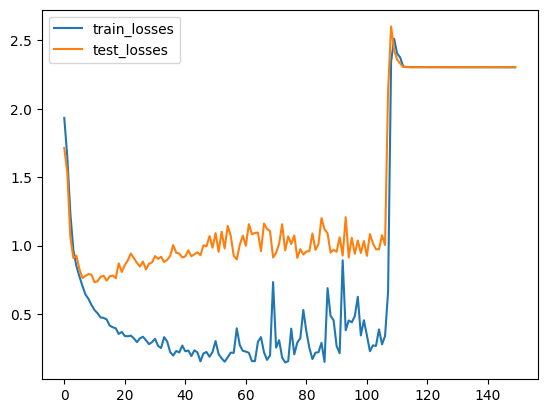

In [9]:
plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

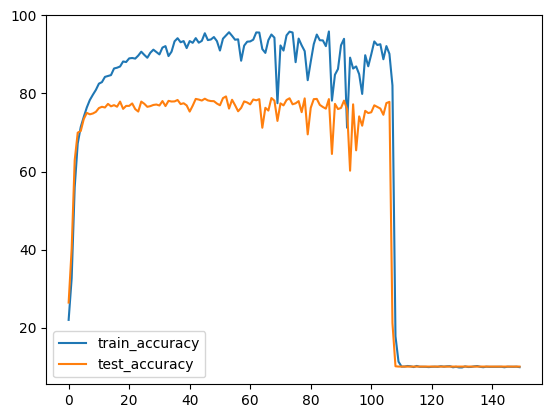

In [10]:
plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()